In [1]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from my_utils import Utils
import glob
import re
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
from my_utils import Utils
import torch
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_3974051/276627886.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
fixed_image='/home-local/rudravg/test_DAPI/testing_it_out/original_image.npy'
moving_image='/home-local/rudravg/test_DAPI/testing_it_out/new_image.npy'
fixed_image_np = np.load(fixed_image)
moving_image_np = np.load(moving_image)
Utils.calculate_ncc(fixed_image_np.ravel(), moving_image_np.ravel())

array([0.82603843])

In [2]:
model_path='/home-local/rudravg/test_DAPI/epochs/epoch_50/epoch_50.pth'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = vxm.networks.VxmDense.load(model_path,device=device)

model.to(device)
model.eval()

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [4]:
# moving = vxm.py.utils.load_volfile(moving_image, add_batch_axis=True, add_feat_axis=True)
# fixed, fixed_affine = vxm.py.utils.load_volfile(
#     fixed_image, add_batch_axis=True, add_feat_axis=True, ret_affine=True)
moving=moving_image_np[np.newaxis,...,np.newaxis]
fixed=fixed_image_np[np.newaxis,...,np.newaxis]

In [5]:
input_moving = torch.from_numpy(moving).to(device).float().permute(0, 3,1,2)
input_fixed = torch.from_numpy(fixed).to(device).float().permute(0, 3,1,2)

In [6]:
moved, warp = model(input_moving, input_fixed, registration=True)

In [7]:
moved = moved.cpu().detach().numpy().squeeze()

(-0.5, 511.5, 511.5, -0.5)

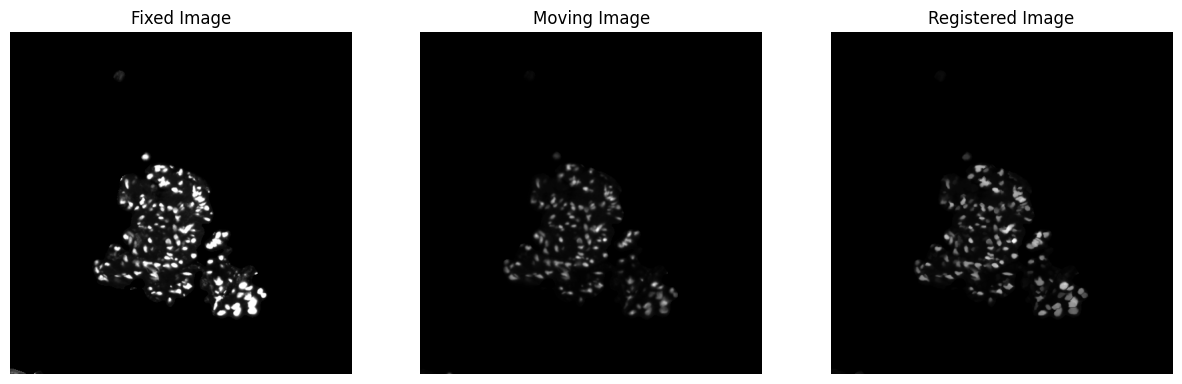

In [8]:
#Plot the images in a single plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(fixed_image_np, cmap='gray')
ax[0].set_title('Fixed Image')
ax[0].axis('off')

ax[1].imshow(moving_image_np, cmap='gray')
ax[1].set_title('Moving Image')
ax[1].axis('off')

ax[2].imshow(moved, cmap='gray')
ax[2].set_title('Registered Image')
ax[2].axis('off')



In [9]:
Utils.calculate_ncc(fixed_image_np.ravel(), moved.ravel())

array([0.94714296])

In [4]:
fixed='/nfs2/baos1/rudravg/GCA112TIA_DAPI_DAPI_30ms_ROUND_00_initial_reg.tif'
moving='/nfs2/baos1/rudravg/GCA112TIA_DAPI_DAPI_12ms_ROUND_19_initial_reg.tif'
mask='/nfs2/baos1/rudravg/Retention_Masks/GCA112TIA_TISSUE_RETENTION.tif'

moving,fixed,orig_height,orig_width=Utils.load_images_and_apply_mask(moving=moving,fixed=fixed,mask=mask)


In [7]:
registered_tissue,_=Utils.register_tissues(moving=moving,fixed=fixed,model=model,device=device)

(-0.5, 2047.5, 2047.5, -0.5)

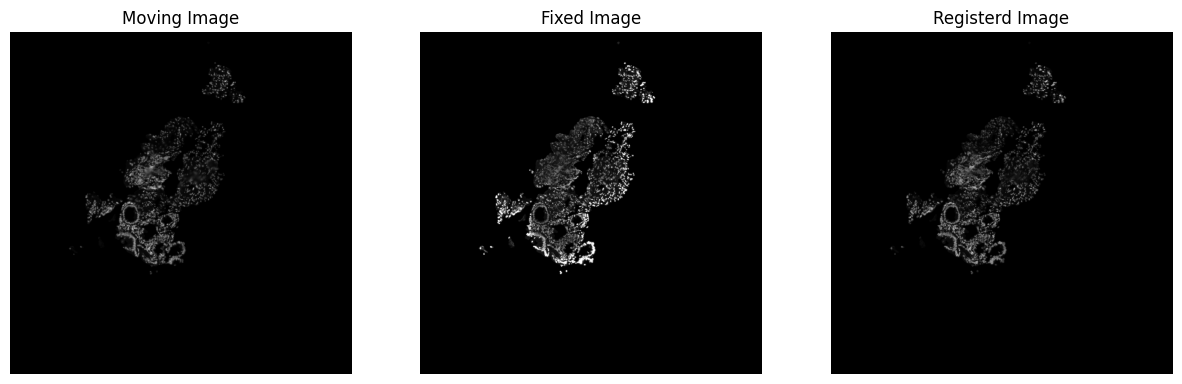

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(moving, cmap='gray')
ax[0].set_title('Moving Image')
ax[0].axis('off')

ax[1].imshow(fixed, cmap='gray')
ax[1].set_title('Fixed Image')
ax[1].axis('off')

ax[2].imshow(registered_tissue, cmap='gray')
ax[2].set_title('Registerd Image')
ax[2].axis('off')

In [10]:
Utils.calculate_ncc(fixed.ravel(), registered_tissue.ravel())

array([0.89864915])

In [11]:
Utils.calculate_ncc(fixed.ravel(), moving.ravel())

array([0.79384689])

In [28]:
block_size=(512,512)
from skimage.util import view_as_blocks
original_tissue_blocks = view_as_blocks(moving, block_shape=block_size)
fixed_blocks = view_as_blocks(fixed, block_shape=block_size)

(-0.5, 511.5, 511.5, -0.5)

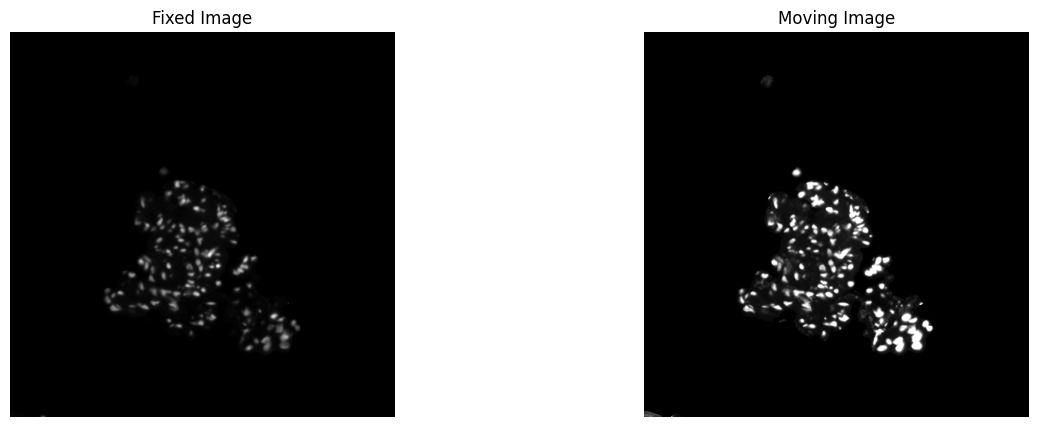

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(original_tissue_blocks[0,2], cmap='gray')
ax[0].set_title('Moving Image')
ax[0].axis('off')

ax[1].imshow(fixed_blocks[0,2], cmap='gray')
ax[1].set_title('Fixed Image')
ax[1].axis('off')



In [30]:
fixed=fixed_blocks[0,2][np.newaxis,...,np.newaxis]
moving=original_tissue_blocks[0,2][np.newaxis,...,np.newaxis]
fixed=torch.from_numpy(fixed).to(device).float().permute(0,3,1,2)
moving=torch.from_numpy(moving).to(device).float().permute(0,3,1,2)
registered=model(moving,fixed ,registration=True)

In [31]:
registered=registered[0].cpu().detach().numpy().squeeze()

(-0.5, 511.5, 511.5, -0.5)

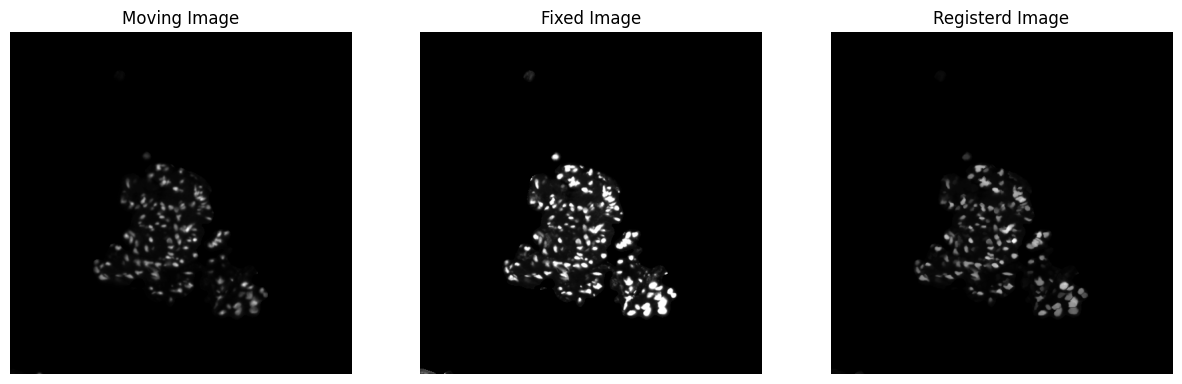

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(original_tissue_blocks[0,2], cmap='gray')
ax[0].set_title('Moving Image')
ax[0].axis('off')

ax[1].imshow(fixed_blocks[0,2], cmap='gray')
ax[1].set_title('Fixed Image')
ax[1].axis('off')

ax[2].imshow(registered, cmap='gray')
ax[2].set_title('Registerd Image')
ax[2].axis('off')

In [34]:
import numpy as np
import torch
from skimage.util import view_as_blocks

# Assuming 'model' and 'device' are already defined and set up.
# Also assuming 'moving' and 'fixed' are your full images that need to be registered.

block_size = (512, 512)  # Define the size of each block
# Create blocks from the images
original_tissue_blocks = view_as_blocks(moving, block_shape=block_size)
fixed_blocks = view_as_blocks(fixed, block_shape=block_size)

# Determine the shape of the block arrays
num_blocks_x, num_blocks_y = original_tissue_blocks.shape[:2]

# Initialize an empty array to hold the registered image blocks
registered_blocks = np.empty_like(original_tissue_blocks)

# Process each block
for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        # Extract blocks and add necessary new axis for model input
        fixed_block = fixed_blocks[i, j][np.newaxis, ..., np.newaxis]
        moving_block = original_tissue_blocks[i, j][np.newaxis, ..., np.newaxis]

        # Convert to PyTorch tensors and prepare dimensions
        fixed_tensor = torch.from_numpy(fixed_block).to(device).float().permute(0, 3, 1, 2)
        moving_tensor = torch.from_numpy(moving_block).to(device).float().permute(0, 3, 1, 2)

        # Predict using the model
        registered_block = model(moving_tensor, fixed_tensor, registration=True)
        registered_block = registered_block[0].cpu().detach().numpy().squeeze()

        # Store the registered block in the array
        registered_blocks[i, j] = registered_block

# Reassemble the registered blocks into a full image
registered_image = np.block(list(map(list, registered_blocks)))

# Further processing can be done here, e.g., saving the image or displaying it.


In [35]:
#Save the images as tiff files at /home-local/rudravg/test_DAPI/Registration_QA/GCA112TIA_masked/Apr14_tissue_reg_check
output_dir='/home-local/rudravg/test_DAPI/Registration_QA/GCA112TIA_masked/Apr14_tissue_reg_check'
os.makedirs(output_dir,exist_ok=True)
output_fixed=os.path.join(output_dir,'fixed.tif')
output_moving=os.path.join(output_dir,'moving.tif')
output_registered=os.path.join(output_dir,'registered.tif')
#Save using Image.save
Image.fromarray(moving).save(output_moving)
Image.fromarray(fixed).save(output_fixed)
Image.fromarray(registered_image).save(output_registered)


In [38]:
Utils.calculate_ncc(fixed.ravel(), registered_image.ravel())

array([0.89864613])

In [40]:
intensity_corrected_image,factor=Utils.adjust_intensity(fixed,registered_image)
print(factor)

2.4796281789225754


/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils.py:20: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)


In [41]:
intesntity_output=os.path.join(output_dir,'intensity_corrected.tif')
Image.fromarray(intensity_corrected_image).save(intesntity_output)

In [42]:
histogram_corrected,factor=Utils.adjust_intensity_histogram(fixed,registered_image)
histogram_output=os.path.join(output_dir,'histogram_corrected.tif')
print(factor)
Image.fromarray(histogram_corrected).save(histogram_output)

1.0082241732693014
